In [1]:
!pip install matplotlib
!pip install nltk
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install scikit-learn
!pip install imbalanced-learn
!pip install transformers
!pip install torch
!pip install sentencepiece
!pip install xgboost
!pip install pandas requests
!pip install tqdm

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 13.2 MB/s eta 0:00:0000:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 14.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 12.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [nltk]4/5 [nltk]b]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached murmurhash-1.0.12-cp313-cp313-macosx_10_13_x86_64.whl.metadata (2.1 kB)
  Using cached cymem-2.0.11-cp31

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
import os

In [ ]:
file_path = os.path.join(os.getcwd(), "csv's", "stat_desc.csv")
df = pd.read_csv(file_path, sep=",", low_memory=False)
df_clean = df.dropna(subset=['catégories']).copy()
df_clean['catégories'] = df_clean['catégories'].astype(int)


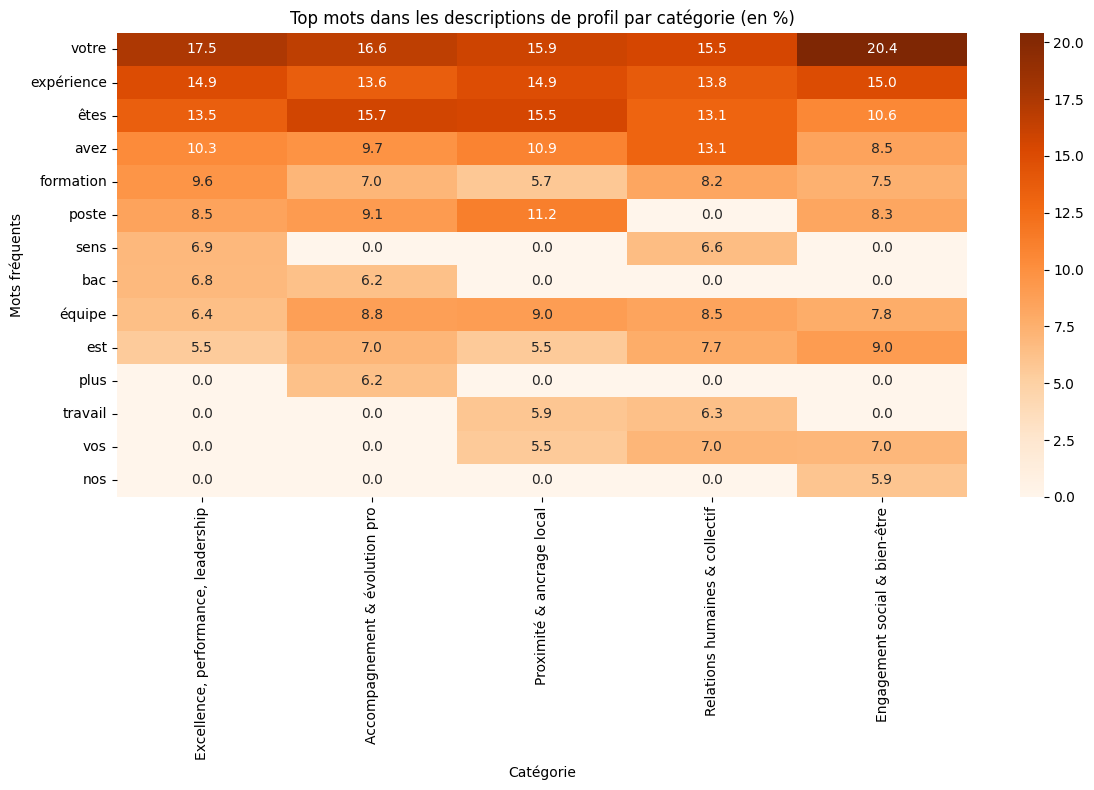

In [4]:
# Définir les labels des catégories
category_labels = {
    1: 'Excellence, performance, leadership',
    2: 'Accompagnement & évolution pro',
    3: 'Proximité & ancrage local',
    4: 'Relations humaines & collectif',
    5: 'Engagement social & bien-être'
}

# Fonction pour extraire les mots les plus fréquents par catégorie
def extract_top_words_by_category(df, column, n=10):
    words_by_cat = {}
    for cat in sorted(df['catégories'].unique()):
        text = df[df['catégories'] == cat][column].dropna().str.lower().str.cat(sep=' ')
        words = re.findall(r"\b\w+\b", text)
        stop_words = {'les','des','pour','avec','dans','sur','de','du','et','la','le','un','une','en','à','par','vous','nous'}
        filtered = [w for w in words if w not in stop_words and len(w) > 2]
        counter = Counter(filtered)
        words_by_cat[cat] = dict(counter.most_common(n))
    return pd.DataFrame(words_by_cat).fillna(0)

# Appliquer la fonction
top_words_df = extract_top_words_by_category(df_clean, 'description_profil', n=10)
# Renommer les colonnes avec les labels
top_words_df.columns = [category_labels[c] for c in top_words_df.columns]

# Transformer en pourcentages par colonne
top_words_df_pct = top_words_df.div(top_words_df.sum(axis=0), axis=1) * 100

# Afficher la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_words_df_pct, annot=True, cmap='Oranges', fmt='.1f')
plt.title("Top mots dans les descriptions de profil par catégorie (en %)")
plt.xlabel("Catégorie")
plt.ylabel("Mots fréquents")
plt.tight_layout()
plt.show()


